In [26]:
import os
import numpy as np
import pandas as pd
import cv2
import scipy
import scipy.stats as stats
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn import metrics
import seaborn as sns
from PIL import Image
import shutil
from functools import reduce
from tqdm.auto import tqdm
import json
from functools import partial
import multiprocessing
import itertools
from statannotations.Annotator import Annotator
import time
import pydicom
import statsmodels.api as sm
sns.set_style('whitegrid')

import tensorflow as tf
from tensorflow import keras
from keras import layers, backend

from src.dataset import Dataset, union_labels
from src import utils

bce = tf.keras.losses.BinaryCrossentropy()

PearsonRResult(statistic=-0.15685411106197822, pvalue=0.5477029019853169) SignificanceResult(statistic=0.11764705882352941, pvalue=0.6529334399539918)


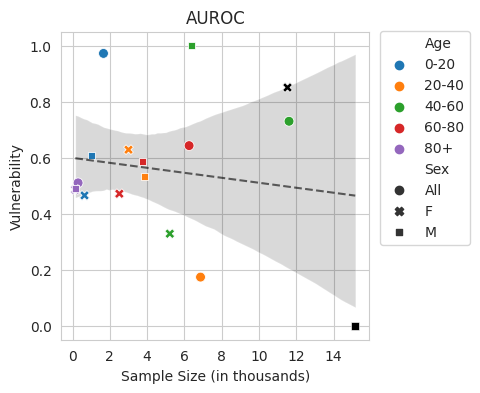

PearsonRResult(statistic=-0.8188217197209211, pvalue=5.832477225991436e-05) SignificanceResult(statistic=-0.8848039215686275, pvalue=2.389164653109702e-06)


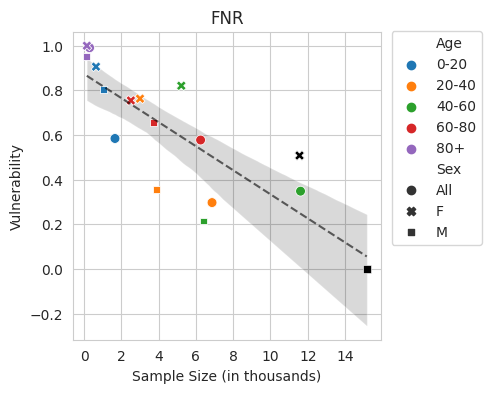

PearsonRResult(statistic=-0.8755578902987877, pvalue=4.1458856699906414e-06) SignificanceResult(statistic=-0.9093137254901962, pvalue=4.274417714447823e-07)


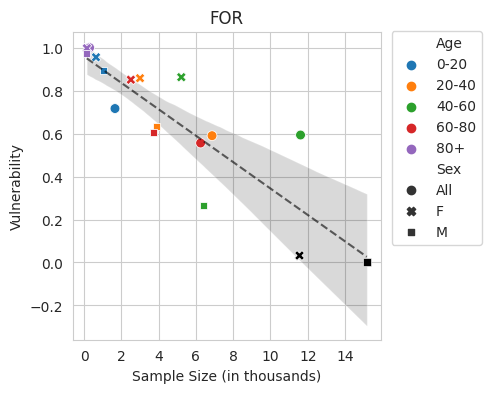

In [55]:
model = 'densenet'
ds = 'rsna'

df = pd.read_csv(f'results/aim_2/{model}/{ds}_summary.csv')

sex_groups = ['M', 'F']
age_groups = ['0-20', '20-40', '40-60', '60-80', '80+']

df_dem = pd.concat((pd.read_csv(f'splits/aim_2/trial_0/train.csv'), pd.read_csv(f'splits/aim_2/trial_0/val.csv'), pd.read_csv(f'splits/aim_2/rsna_test.csv')))

for metric in ['auroc', 'fnr', 'fomr']:
  results = []
  
  for sex in sex_groups:
    group_size = len(df_dem[df_dem.Sex == sex])
    df_t = df[(df.target_sex == sex) & (df.target_age.isna())]
    df_group = pd.DataFrame(df_t[(df_t.dem_sex == sex) & (df_t.dem_age.isna())])
    df_all = pd.DataFrame(df_t[(df_t.dem_sex.isna()) & (df_t.dem_age.isna())])
    
    df_diff = df_group.copy()
    df_diff[metric] = df_all[metric].values - df_group[metric].values
    df_diff[f'{metric}_diff'] = df_diff[['trial', 'rate', metric]].groupby('trial').diff()[metric].values
    df_diff = df_diff[df_diff.rate != 0]
    
    x = df_diff['rate'].values
    y = df_diff[f'{metric}_diff'].values
    y = sm.add_constant(y)
    logit = sm.Logit(x, y).fit(disp=0)
    vul = logit.params[-1]
    
    # df_group[f'{metric}_diff'] = df_group[['trial', 'rate', metric]].groupby('trial').diff()[metric].values
    # df_group = df_group[df_group.rate != 0]
    # df_all[f'{metric}_diff'] = df_all[['trial', 'rate', metric]].groupby('trial').diff()[metric].values
    # df_all = df_all[df_all.rate != 0]
    
    # x = df_group['rate'].values
    # y_group = df_group[f'{metric}_diff'].values
    # y_all = df_all[f'{metric}_diff'].values
    
    # y_group = sm.add_constant(y_group)
    # y_all = sm.add_constant(y_all)
    
    # coeff_group = sm.Logit(x, y_group).fit(disp=0).params[-1]
    # coeff_all = sm.Logit(x, y_all).fit(disp=0).params[-1]

    # vul = np.abs(coeff_all - coeff_group)#/group_size
    
    results += [[sex, np.nan, group_size/1000, vul]]
     
  for age in age_groups:
    group_size = len(df_dem[df_dem.Age_group == age])
    df_t = df[(df.target_sex.isna()) & (df.target_age == age)]
    df_group = pd.DataFrame(df_t[(df_t.dem_sex.isna()) & (df_t.dem_age == age)])
    df_all = pd.DataFrame(df_t[(df_t.dem_sex.isna()) & (df_t.dem_age.isna())])
    
    df_diff = df_group.copy()
    df_diff[metric] = df_all[metric].values - df_group[metric].values
    df_diff[f'{metric}_diff'] = df_diff[['trial', 'rate', metric]].groupby('trial').diff()[metric].values
    df_diff = df_diff[df_diff.rate != 0]
    
    x = df_diff['rate'].values
    y = df_diff[f'{metric}_diff'].values
    y = sm.add_constant(y)
    logit = sm.Logit(x, y).fit(disp=0)
    vul = logit.params[-1]
    
    # df_group[f'{metric}_diff'] = df_group[['trial', 'rate', metric]].groupby('trial').diff()[metric].values
    # df_group = df_group[df_group.rate != 0]
    # df_all[f'{metric}_diff'] = df_all[['trial', 'rate', metric]].groupby('trial').diff()[metric].values
    # df_all = df_all[df_all.rate != 0]
    
    # df_diff = df_group.copy()
    # df_diff[metric] = df_group[f'{metric}_diff'].values/df_all[f'{metric}_diff'].values
    
    # x = df_group['rate'].values
    # y_group = df_group[f'{metric}_diff'].values
    # y_all = df_all[f'{metric}_diff'].values
    
    # y_group = sm.add_constant(y_group)
    # y_all = sm.add_constant(y_all)
    
    # coeff_group = sm.Logit(x, y_group).fit(disp=0).params[-1]
    # coeff_all = sm.Logit(x, y_all).fit(disp=0).params[-1]
    
    # vul = np.abs(coeff_all - coeff_group)#/group_size
    
    results += [['All', age, group_size/1000, vul]]

  if model == 'densenet':  
    for sex in sex_groups:
      for age in age_groups:
        group_size = len(df_dem[(df_dem.Sex == sex) & (df_dem.Age_group == age)])
        df_t = df[(df.target_sex == sex) & (df.target_age == age)]
        df_group = pd.DataFrame(df_t[(df_t.dem_sex == sex) & (df_t.dem_age == age)])
        df_all = pd.DataFrame(df_t[(df_t.dem_sex.isna()) & (df_t.dem_age.isna())])
        
        df_diff = df_group.copy()
        df_diff[metric] = df_all[metric].values - df_group[metric].values
        df_diff[f'{metric}_diff'] = df_diff[['trial', 'rate', metric]].groupby('trial').diff()[metric].values
        df_diff = df_diff[df_diff.rate != 0]
        
        x = df_diff['rate'].values
        y = df_diff[f'{metric}_diff'].values
        y = sm.add_constant(y)
        logit = sm.Logit(x, y).fit(disp=0)
        vul = logit.params[-1]
        
        # df_group[f'{metric}_diff'] = df_group[['trial', 'rate', metric]].groupby('trial').diff()[metric].values
        # df_group = df_group[df_group.rate != 0]
        # df_all[f'{metric}_diff'] = df_all[['trial', 'rate', metric]].groupby('trial').diff()[metric].values
        # df_all = df_all[df_all.rate != 0]
        
        # x = df_group['rate'].values
        # y_group = df_group[f'{metric}_diff'].values
        # y_all = df_all[f'{metric}_diff'].values
        
        # y_group = sm.add_constant(y_group)
        # y_all = sm.add_constant(y_all)
        
        # coeff_group = sm.Logit(x, y_group).fit(disp=0).params[-1]
        # coeff_all = sm.Logit(x, y_all).fit(disp=0).params[-1]
        
        # vul = np.abs(coeff_all - coeff_group)#/group_size

        results += [[sex, age, group_size/1000, vul]]

    
  df_results = pd.DataFrame(results, columns=['Sex', 'Age', 'count', 'coeff']).sort_values(['Sex', 'Age'])
  df_results['coeff'] = (df_results['coeff'] - df_results['coeff'].min())/(df_results['coeff'].max() - df_results['coeff'].min())
  # df_results.to_csv(f'results/aim_2/{model}/{ds}_vul_{metric}.csv', index=False)

  x = df_results['count'].values
  y = df_results['coeff'].values
  print(stats.pearsonr(x, y), stats.spearmanr(x, y))
  plt.figure(figsize=(6,4))
  # plt.figure(figsize=(2,2))

  sns.regplot(data=df_results, x='count', y='coeff', scatter=False, logistic=False, color='black', line_kws=dict(alpha=0.6, linestyle='--', linewidth=1.5))
  sns.scatterplot(data=df_results, x='count', y='coeff', hue='Age', style='Sex', s=50)
  sns.scatterplot(data=df_results[(df_results.Age.isna()) & (df_results.Sex == 'M')], x='count', y='coeff', color='black', marker='s', s=30)
  sns.scatterplot(data=df_results[(df_results.Age.isna()) & (df_results.Sex == 'F')], x='count', y='coeff', color='black', marker='X', s=50)
  ####
  plt.legend(bbox_to_anchor=(1.35, 1.025), loc='upper right')
  if metric != 'fomr':
    plt.title(metric.upper())
  else:
    plt.title('FOR')
  plt.xlabel('Sample Size (in thousands)')
  plt.ylabel('Vulnerability')
  ratio = 1.0
  ax = plt.gca()
  x_left, x_right = ax.get_xlim()
  y_low, y_high = ax.get_ylim()
  ax.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)
  ax.set_xticks([0, 2, 4, 6, 8, 10, 12, 14])
  # plt.savefig(f'results/aim_2/{model}/{ds}_vul_{metric}.png', bbox_inches='tight', dpi=300)
  plt.show()
  ####
  # if metric == 'auroc':
  #   y_max = 0.1
  # elif metric == 'fnr':
  #   y_max = 0.02
  # else:
  #   y_max = 0.05
  # plt.xlabel(None)
  # plt.ylabel(None)
  # plt.axis((0, 4, 0, y_max))
  # ratio = 1.0
  # ax = plt.gca()
  # x_left, x_right = ax.get_xlim()
  # y_low, y_high = ax.get_ylim()
  # ax.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)
  # ax.set_xticks([0, 1, 2, 3, 4])
  # plt.legend().remove()
  # # plt.savefig(f'results/aim_2/{model}/{ds}_vul_{metric}_zoom.png', bbox_inches='tight', dpi=300)
  # plt.show()

In [53]:
model = 'inception'
ds = 'rsna'

df_vul = pd.merge(pd.read_csv(f'results/aim_2/{model}/{ds}_vul_auroc.csv'), pd.read_csv(f'results/aim_2/{model}/{ds}_vul_fnr.csv'), on=['Sex', 'Age', 'count'], suffixes=['_auroc', '_fnr'])
df_vul = pd.merge(df_vul, pd.read_csv(f'results/aim_2/{model}/{ds}_vul_fomr.csv'), on=['Sex', 'Age', 'count'])
df_vul['coeff_for'] = df_vul['coeff']
df_vul = df_vul[['Sex', 'Age', 'coeff_auroc', 'coeff_fnr', 'coeff_for']]
df_vul['Sex'][df_vul.Sex == 'All'] = np.nan
df_vul = df_vul.sort_values(['Sex', 'Age'])
df_vul.to_csv(f'results/aim_2/{model}/{ds}_vul_values.csv', index=False)

In [54]:
df_vul

,Sex,Age,coeff_auroc,coeff_fnr,coeff_for
5,F,NaN,0.875904,0.513516,0.032716
6,M,NaN,0.000000,0.000000,0.000000
0,NaN,0-20,1.000000,0.589851,0.716607
1,NaN,20-40,0.178611,0.300256,0.590328
2,NaN,40-60,0.750784,0.351906,0.593433
3,NaN,60-80,0.661384,0.582983,0.556242
4,NaN,80+,0.524606,1.000000,1.000000
